# Week 3: CNN Cancer Detection Kaggle Mini-Project

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.metrics import AUC

In [2]:
# Loading the Kaggle data locally

# install Kaggle
#! pip install -q kaggle

from google.colab import files
files.upload()

# create a kaggle folder
! mkdir ~/.kaggle

# copy the kaggle.json to the folder we created
! cp kaggle.json ~/.kaggle/

# permission for the json to act
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c histopathologic-cancer-detection

! unzip histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d

In [3]:
# get filepaths

test_path = '/content/test/'
train_path = '/content/train/'
sample_submission = pd.read_csv('/content/sample_submission.csv')
train_data = pd.read_csv('/content/train_labels.csv')

## 1. Brief Description of the Problem and Data

In this project we are tasked with using the Convolutional Neural Network methods that we've been learning in class to develop a binary classifier for metastatic cancer tissue in scans of lymph node sections. Let's take an initial look at the makeup of our training data. 

In [4]:
train_data

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0


We see here that our training dataset is made up of 220,025 images of lymph node scans, each of which is labeled as cancerous (1) or non-cancerous (0). 

In [5]:
# Let's see what the filenames look like in the train directories

train_fnames = os.listdir(train_path)
print(train_fnames[:10])

test_fnames = os.listdir(test_path)
print(test_fnames[:10])

['8dc222326e1a5133d6aac234e02e9530f0ca1703.tif', '3d684035517c02e62502b431e75b41fcebd41f0a.tif', '241864b23c400030badccbd35df84caf1cd8f0bb.tif', '4dfe11fa03834e83c3f0758b657bbf763deed1b0.tif', 'a23bc963cd813ed415ae5897e07bffd38c7f43fc.tif', 'e6a1a1d3a85945dbc26929b75271b1c585e4fe3e.tif', '57faf38624f1085e936f779626a3f325f9bfb011.tif', 'e239b5aad4f8cff328496d066cfba9856ccc4bb5.tif', '20548b1ab6ab6303a4bbd5e6a2e8f9a3cfa88128.tif', 'e6b81b726feba2190e53edeaae420dfb5ce74219.tif']
['53aab988d2ba9f33b2c002404d864202f97a8f6a.tif', '4e60036f4400930fcb880a67a4414c130288e8a0.tif', '1f2b6eecbc3250fbecd5b8bfaffa69b8a5d11e05.tif', 'd86b70f48a4a0bf9b2b728b6776a671580292a43.tif', '88c28f29c6d6b0901cd4dff941fc04c4b497c740.tif', 'ae615f82d3406a57dd5cc56c691025698e522f8a.tif', '2f4306e5f20e99ef2f53a8bc1f541ef620f4974e.tif', '23f380ada694d70e7c4b84a56291b0b18497f9f0.tif', 'a708c1a4393c4e2fa7b8cf4c55279f8bd7df686d.tif', 'ba457d045d9901fe09b508988cbcd97ad15605a8.tif']


Each string in the "id" column corresponds to a ".tif" file in the accompanying folder of training data. The same is true for the test data. 

In [6]:
# total number of images in each directory

print('total training images:', len(train_fnames))
print('total test images:', len(test_fnames))

print('total number of images:', len(train_fnames) + len(test_fnames))

total training images: 220025
total test images: 57458
total number of images: 277483


## 2. Exploratory Data Analysis (EDA)

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


Thankfully, we see that this data has been well cleaned. There is no indication of any null or irregular values present in the training data. 

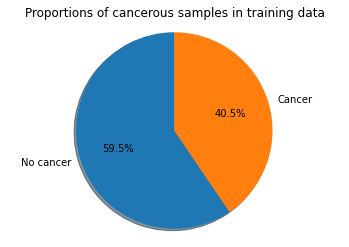

In [8]:
# Pie chart to illustrate the relative proportions of each response

fig, ax = plt.subplots()
ax.pie(
    train_data['label'].value_counts(),
    labels = ['No cancer', 'Cancer'], 
    autopct = '%1.1f%%', 
    shadow = True, 
    startangle = 90)
ax.axis('equal')
ax.set_title('Proportions of cancerous samples in training data')
plt.show()


We see here that the makeup of our training data is skewed somewhat towards non-cancerous samples. For consistency as we tune our model, it may be a good idea to pull a sample of equal proportions of cancerous and non-cancerous samples. 

In [9]:
# to avoid blowing up the computer, let's start with 5000 of each type of data

# change the id's of train_data to reflect the actual filepaths, for ease
train_data['id'] = train_data['id'] + '.tif'

# set sample parameters
rand_state = 144
sample_size = 5000

df_neg = train_data[train_data['label']==0].sample(sample_size, random_state = rand_state)
df_pos = train_data[train_data['label']==1].sample(sample_size, random_state = rand_state)

sample_df = pd.concat([df_neg, df_pos])
sample_df = sample_df.sample(frac=1)
sample_df = sample_df.reset_index(drop = True)
sample_df


,id,label
0,df7c4f114ce8a809aa1725de1f35b11ee1a48ed5.tif,0
1,87b009e29d5dbfba92d55b3390b9d70e3341664b.tif,1
2,bfbc463a4a6dc9c1560d863579882cecbb3436fb.tif,0
3,f7062bb9e3f581025a434b140b6270b4a3cddb4b.tif,1
4,26903de04b86385a5687e0c8a8d30f90c0de9518.tif,0
...,...,...
9995,338dd644b96fc9a5a9903af887119eaaec3aece8.tif,1
9996,c12aaff45ecf29e0674c08c5d9396e82cd559fa7.tif,0
9997,8cb76f0a75617f1d6a3b539fd477580ebaf0aa11.tif,0
9998,41536169a3fdf634486828ed7dee8717a2aca7dd.tif,0


Now that we have our sample dataset ready for initial model exploration, let's use the directory to take a look at a few of the images in the training data folder. 

Image size:  (96, 96, 3) 



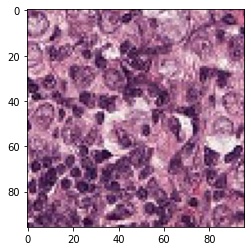

In [10]:
# how big is each starting image?

img = mpimg.imread(os.path.join(train_path, train_fnames[np.random.randint(0, 1000)]))
plt.imshow(img)
print("Image size: ", img.shape, '\n')
plt.show()


Each image, as seen here, is of size 96x96x3 (representing the three color channels). 

In [11]:
# We want to display images in a 4x4 grid
nrows = 4
ncols = 4

# Iteration index
pic_index = 0

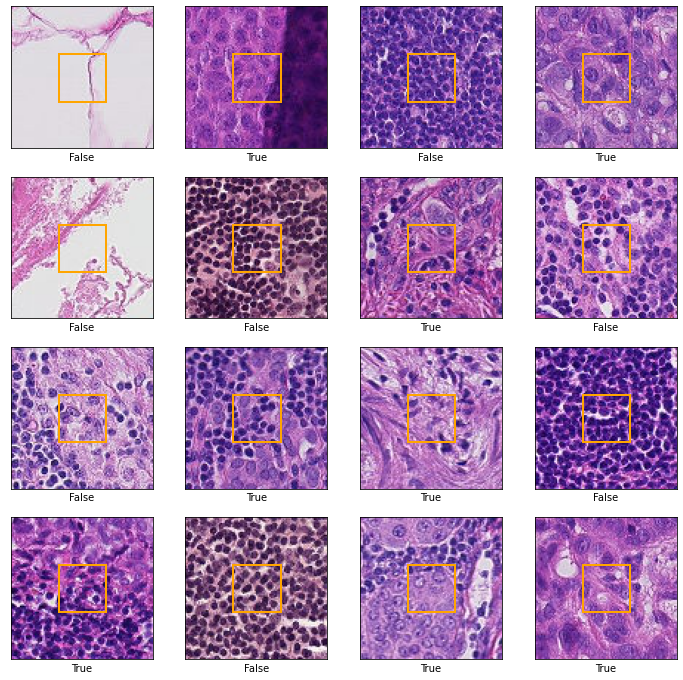

In [12]:
# Set our matplotlib figure
fig, axs = plt.subplots(nrows, ncols, figsize=(12,12))

# load a new set of images every time the cell runs
pic_index += nrows * ncols
next_pics = sample_df[pic_index-nrows*ncols : pic_index].reset_index()


for i, axis in enumerate(axs.flat):
  fname = os.path.join(train_path, next_pics['id'][i])
  label = bool(next_pics['label'][i])
  img = mpimg.imread(fname)
  axis.imshow(img)
  axis.set_xticks([])
  axis.set_yticks([])
  axis.set_xlabel(label)
  box = patches.Rectangle((32, 32), 32, 32, linewidth = 2, edgecolor = 'orange', facecolor = 'None', linestyle = '-')
  axis.add_patch(box)

plt.show()

Here we can see a visual representation of some of our sample data, along with the corresponding label for cancerous and non-cancerous samples. Each image is overlaid with an orange circle that corresponds to the 32x32 pixel square within which our classifier is supposed to be looking for evidence of cancer. 

## 3. Model Architecture

###First Model

For this project, We'll be using the Keras API to train and test a series of Convolutional Neural Networks (CNN's). 

Our base architecture will consist of a three convolutional layers, each interspersed with max-pooling layers, followed finally by a single dense layer before the output. In summary:

1. Input
2. Conv2D (ReLu activation)
3. MaxPool
4. Conv2D (ReLu activation)
5. MaxPool
6. Conv2D (ReLu activation)
7. MaxPool
8. Flatten
9. Dense (ReLu activation)
10. Output (sigmoid activation)

**Normalization:** we will normalize the pixel data of each image prior to training by dividing each value by 255.

**Loss:** we use the binary crossentropy loss function, since we have a binary classification problem with a sigmoid activation. 

**Optimization:** we will use  Adam (Adaptive Moment Estimation) as our optimization algorithm, since it adapts the learning rate for us and incorporates a momentum coefficient when updating weights. 

**Batch Sizes:** following methods that we learned in our week 2 work on Stochastic Gradient Descent, we'll apply a mini-batch method for training. Specifically, we'll use a relatively small batch size of 100 (relative to the sample dataset size of 10,000). 

In [13]:
batch_size = 100

# Rescale all images by 1/255
datagen = ImageDataGenerator(rescale = 1/255, 
                             validation_split = 0.2)

# Flow training images in batches of 100 using the datagen generator
train_generator = datagen.flow_from_dataframe(dataframe = sample_df,
                                              x_col = 'id', 
                                              y_col = 'label', 
                                              directory = train_path, 
                                              batch_size = batch_size, 
                                              class_mode = 'raw', 
                                              subset = 'training', 
                                              seed = rand_state, 
                                              target_size = (96, 96))

# Flow validation images in batches of 100 using the datagen generator
validation_generator = datagen.flow_from_dataframe(dataframe = sample_df, 
                                                   x_col = 'id', 
                                                   y_col = 'label', 
                                                   directory = train_path, 
                                                   batch_size = batch_size, 
                                                   class_mode = 'raw', 
                                                   subset = 'validation', 
                                                   seed = rand_state, 
                                                   target_size = (96, 96))

Found 8000 validated image filenames.
Found 2000 validated image filenames.


In [14]:
# Building a test CNN

# Input feature map is 96x96x3
img_input = layers.Input(shape=(96, 96, 3))

# First convolutional layer extracts 16 filters that are 3x3
x = layers.Conv2D(16, 3, activation = 'relu')(img_input)

# Max-pooling layer with 2x2 window
x = layers.MaxPooling2D(2)(x)

# Second convolutional layer extracts 32 filters that are 3x3
x = layers.Conv2D(32, 3, activation = 'relu')(x)

# Max-pooling layer with 2x2 window
x = layers.MaxPooling2D(2)(x)

# Third convolutional layer extracts 64 filters that are 3x3
x = layers.Conv2D(64, 3, activation = 'relu')(x)

# Max-pooling layer with 2x2 window
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to 1D tensor for fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with Relu activation, 512 hidden units
x = layers.Dense(512, activation = 'relu')(x)

# Output layer with sigmoid activation
output = layers.Dense(1, activation = 'sigmoid')(x)

# Create model
model_1 = Model(img_input, output)

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496 

In [15]:
# Configure specifications for model training, using binary crossentropy loss
AUC_1 = AUC()

model_1.compile(loss = 'binary_crossentropy', 
              optimizer = Adam(learning_rate = 0.001), 
              metrics = ['acc', AUC_1])

In [16]:
# Train on all 8k images of the sample we've taken, and validate on all 2k validation images

num_epochs = 15 

history_1 = model_1.fit(train_generator,
                    steps_per_epoch = 80, 
                    epochs = num_epochs, 
                    validation_data = validation_generator,
                    validation_steps = 20, 
                    verbose = 2)

Epoch 1/15
80/80 - 32s - loss: 0.5632 - acc: 0.7205 - auc: 0.7883 - val_loss: 0.4925 - val_acc: 0.7775 - val_auc: 0.8441 - 32s/epoch - 395ms/step
Epoch 2/15
80/80 - 6s - loss: 0.4823 - acc: 0.7791 - auc: 0.8502 - val_loss: 0.5002 - val_acc: 0.7600 - val_auc: 0.8538 - 6s/epoch - 77ms/step
Epoch 3/15
80/80 - 6s - loss: 0.4730 - acc: 0.7768 - auc: 0.8563 - val_loss: 0.4724 - val_acc: 0.7805 - val_auc: 0.8571 - 6s/epoch - 74ms/step
Epoch 4/15
80/80 - 6s - loss: 0.4629 - acc: 0.7914 - auc: 0.8631 - val_loss: 0.4999 - val_acc: 0.7655 - val_auc: 0.8545 - 6s/epoch - 75ms/step
Epoch 5/15
80/80 - 6s - loss: 0.4448 - acc: 0.7976 - auc: 0.8747 - val_loss: 0.4649 - val_acc: 0.7950 - val_auc: 0.8636 - 6s/epoch - 75ms/step
Epoch 6/15
80/80 - 6s - loss: 0.4294 - acc: 0.8073 - auc: 0.8841 - val_loss: 0.4662 - val_acc: 0.7850 - val_auc: 0.8653 - 6s/epoch - 81ms/step
Epoch 7/15
80/80 - 6s - loss: 0.4023 - acc: 0.8224 - auc: 0.8996 - val_loss: 0.5351 - val_acc: 0.7630 - val_auc: 0.8522 - 6s/epoch - 73ms/s

In [17]:
def diagnostic_plots(history):
  # A helper function to display the accuracy, loss and AUC for each model that we train. 
  # Import: a history object returned from tf.keras.Model.fit()
  # Displays a plot of accuracy, loss, and auc for training and validation data
  fig, axs = plt.subplots(nrows = 1, ncols = 3, sharey = True, figsize = (20,4))

  n_epochs = len(history.history['acc'])

  train_acc = history.history['acc']
  val_acc = history.history['val_acc']
  axs[0].plot(range(n_epochs), train_acc)
  axs[0].plot(range(n_epochs), val_acc)
  axs[0].set_title('Accuracy')
  axs[0].legend(['train', 'validate'], loc = 'upper left') 

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  axs[1].plot(range(n_epochs), train_loss)
  axs[1].plot(range(n_epochs), val_loss)
  axs[1].set_title('Loss')
  axs[1].legend(['train', 'validate'], loc = 'upper left')

  t_str = list(history.history.keys())[2]
  v_str = list(history.history.keys())[5]
  train_auc = history.history[t_str]
  val_auc = history.history[v_str]
  axs[2].plot(range(n_epochs), train_auc)
  axs[2].plot(range(n_epochs), val_auc)
  axs[2].set_title('AUC')
  axs[2].legend(['train', 'validate'], loc = 'upper left')


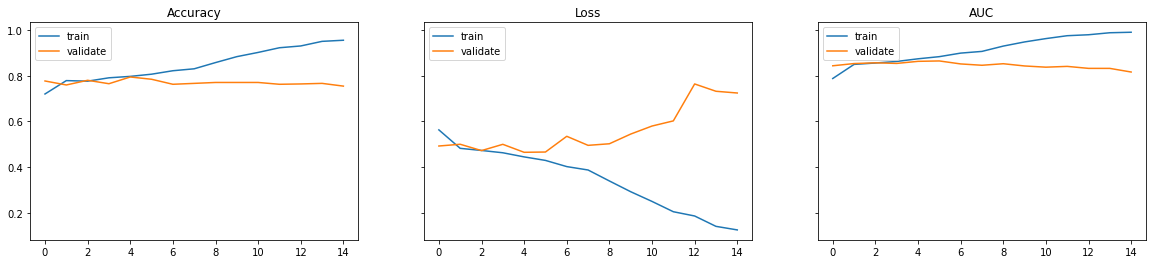

In [18]:
diagnostic_plots(history_1)

Our diagnostic plots here show that our initial model is overfitting heavily. Our training accuracy is almost immediately pushing 100%, whereas out validation accuracy stalls at around 75% initially. The loss plot mirrors this, with validation loss rising considerably above our training loss. AUC (our chosen evaluation metric for this competition) similarly flatlines quite early.

### Second Model

For our second model, we'll use the same base model architecture, but incorporate some additional features to try and improve performance:

**Data Augmentation:** we will "augment" our data via a series of random transformations in order to ensure a more considerable variability in the types of images on which our model trains, allowing it to generalize patterns more effectively. 

**Dropout:** here, we'll randomly drop out unit activations in a network for a single gradient step, resulting in stronger regularization. The degree of dropout regularization (between 0.0 and 1.0) is the primary hyperparameter that we'll try to tune in this study. 

In [19]:
# Configuring random transformations to be performed on the images for our second model attempt

datagen_2 = ImageDataGenerator(
    rotation_range = 180,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2,
    horizontal_flip = True, 
    vertical_flip = True,
    fill_mode = 'nearest',
    rescale = 1/255,  
    validation_split = 0.2
)

batch_size = 100
num_epochs = 15 

# Flow training images in batches of 100 using the generator
train_generator_2 = datagen_2.flow_from_dataframe(dataframe = sample_df,
                                              x_col = 'id', 
                                              y_col = 'label', 
                                              directory = train_path, 
                                              batch_size = batch_size, 
                                              class_mode = 'raw', 
                                              subset = 'training', 
                                              seed = rand_state, 
                                              target_size = (96, 96))

# Flow validation images in batches of 100 using the generator
validation_generator_2 = datagen_2.flow_from_dataframe(dataframe = sample_df, 
                                                   x_col = 'id', 
                                                   y_col = 'label', 
                                                   directory = train_path, 
                                                   batch_size = batch_size, 
                                                   class_mode = 'raw', 
                                                   subset = 'validation', 
                                                   seed = rand_state, 
                                                   target_size = (96, 96))

Found 8000 validated image filenames.
Found 2000 validated image filenames.


In [20]:
# Building a second CNN with dropout

# Input feature map is 96x96x3
img_input = layers.Input(shape=(96, 96, 3))

# First convolutional layer extracts 16 filters that are 3x3
x = layers.Conv2D(16, 3, activation = 'relu')(img_input)

# Max-pooling layer with 2x2 window
x = layers.MaxPooling2D(2)(x)

# Second convolutional layer extracts 32 filters that are 3x3
x = layers.Conv2D(32, 3, activation = 'relu')(x)

# Max-pooling layer with 2x2 window
x = layers.MaxPooling2D(2)(x)

# Third convolutional layer extracts 64 filters that are 3x3
x = layers.Conv2D(64, 3, activation = 'relu')(x)

# Max-pooling layer with 2x2 window
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to 1D tensor for fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with Relu activation, 512 hidden units
x = layers.Dense(512, activation = 'relu')(x)

# Add a dropout layer with rate = 0.2
x = layers.Dropout(0.5)(x)

# Output layer with sigmoid activation
output = layers.Dense(1, activation = 'sigmoid')(x)

# Create model
model_2 = Model(img_input, output)

model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 64)        1849

In [21]:
AUC_2 = AUC()

model_2.compile(
    loss = 'binary_crossentropy', 
    optimizer = Adam(learning_rate = 0.001), 
    metrics = ['acc', AUC_2]
)

In [22]:
history_2 = model_2.fit(
    train_generator_2,
    steps_per_epoch = 80, 
    epochs = num_epochs, 
    validation_data = validation_generator_2,
    validation_steps = 20,
    verbose = 2)

Epoch 1/15
80/80 - 26s - loss: 0.6369 - acc: 0.6288 - auc_1: 0.6893 - val_loss: 0.5672 - val_acc: 0.7350 - val_auc_1: 0.8108 - 26s/epoch - 324ms/step
Epoch 2/15
80/80 - 26s - loss: 0.5312 - acc: 0.7499 - auc_1: 0.8137 - val_loss: 0.5161 - val_acc: 0.7580 - val_auc_1: 0.8369 - 26s/epoch - 321ms/step
Epoch 3/15
80/80 - 25s - loss: 0.5114 - acc: 0.7582 - auc_1: 0.8285 - val_loss: 0.5102 - val_acc: 0.7615 - val_auc_1: 0.8446 - 25s/epoch - 308ms/step
Epoch 4/15
80/80 - 24s - loss: 0.5039 - acc: 0.7651 - auc_1: 0.8345 - val_loss: 0.4823 - val_acc: 0.7860 - val_auc_1: 0.8498 - 24s/epoch - 306ms/step
Epoch 5/15
80/80 - 25s - loss: 0.4987 - acc: 0.7666 - auc_1: 0.8388 - val_loss: 0.5111 - val_acc: 0.7550 - val_auc_1: 0.8510 - 25s/epoch - 308ms/step
Epoch 6/15
80/80 - 25s - loss: 0.4941 - acc: 0.7679 - auc_1: 0.8415 - val_loss: 0.4871 - val_acc: 0.7740 - val_auc_1: 0.8552 - 25s/epoch - 308ms/step
Epoch 7/15
80/80 - 25s - loss: 0.4804 - acc: 0.7740 - auc_1: 0.8511 - val_loss: 0.4638 - val_acc: 0.

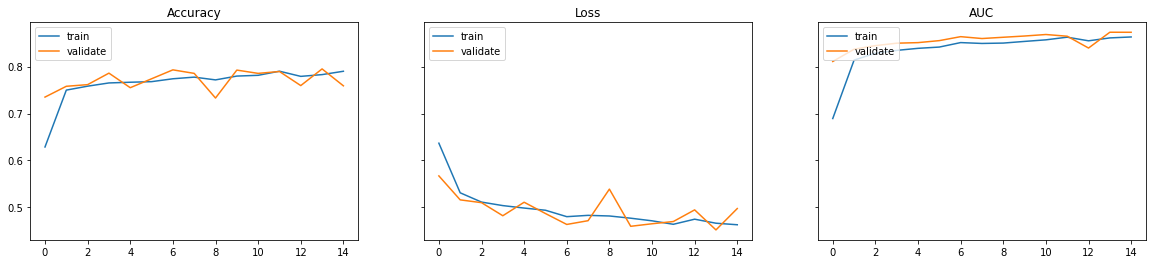

In [23]:
diagnostic_plots(history_2)

We see a significant improvement here, with the addition of image augmentation and droupout regularization. Next, we'll iterate through a few different dropout values (training on 10 epochs each) to see which gives us the best results. 

In [25]:
def CNN_dropout_tuner(dropouts):
  # Iterates through the input dropout values, training a model and printing out diagnostic plots for each

  for dropout in dropouts:
    print("Dropout value: ", dropout, '\n')

    # Create default model
    img_input = layers.Input(shape=(96, 96, 3))
    x = layers.Conv2D(16, 3, activation = 'relu')(img_input)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(32, 3, activation = 'relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation = 'relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation = 'relu')(x)
    x = layers.Dropout(dropout)(x)
    output = layers.Dense(1, activation = 'sigmoid')(x)
    model = Model(img_input, output)

    model.compile(
        loss = 'binary_crossentropy', 
        optimizer = Adam(learning_rate = 0.001), 
        metrics = ['acc', AUC()])
    
    history = model.fit(
        train_generator_2,
        steps_per_epoch = 80, 
        epochs = 10, 
        validation_data = validation_generator_2,
        validation_steps = 20,
        verbose = 2)
    
    diagnostic_plots(history)


Dropout value:  0.2 

Epoch 1/10
80/80 - 26s - loss: 0.6252 - acc: 0.6562 - auc_2: 0.7137 - val_loss: 0.5291 - val_acc: 0.7580 - val_auc_2: 0.8227 - 26s/epoch - 331ms/step
Epoch 2/10
80/80 - 25s - loss: 0.5223 - acc: 0.7490 - auc_2: 0.8191 - val_loss: 0.4922 - val_acc: 0.7780 - val_auc_2: 0.8433 - 25s/epoch - 308ms/step
Epoch 3/10
80/80 - 24s - loss: 0.4943 - acc: 0.7670 - auc_2: 0.8413 - val_loss: 0.4757 - val_acc: 0.7830 - val_auc_2: 0.8562 - 24s/epoch - 305ms/step
Epoch 4/10
80/80 - 24s - loss: 0.4995 - acc: 0.7671 - auc_2: 0.8379 - val_loss: 0.5003 - val_acc: 0.7785 - val_auc_2: 0.8548 - 24s/epoch - 305ms/step
Epoch 5/10
80/80 - 25s - loss: 0.4984 - acc: 0.7648 - auc_2: 0.8383 - val_loss: 0.4693 - val_acc: 0.7875 - val_auc_2: 0.8597 - 25s/epoch - 308ms/step
Epoch 6/10
80/80 - 25s - loss: 0.4853 - acc: 0.7754 - auc_2: 0.8479 - val_loss: 0.4964 - val_acc: 0.7635 - val_auc_2: 0.8500 - 25s/epoch - 308ms/step
Epoch 7/10
80/80 - 28s - loss: 0.4758 - acc: 0.7794 - auc_2: 0.8544 - val_loss

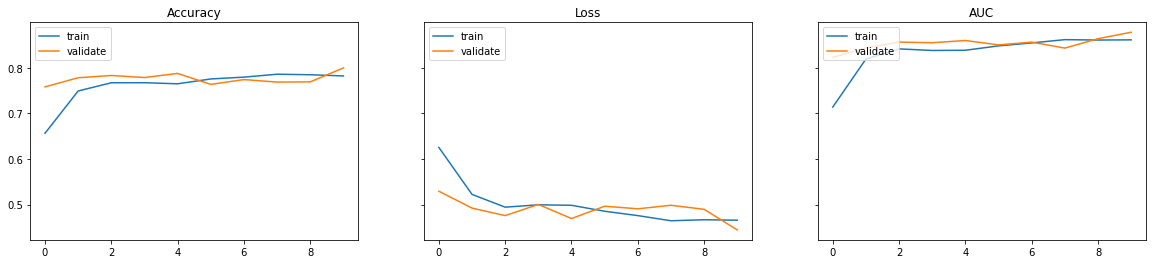

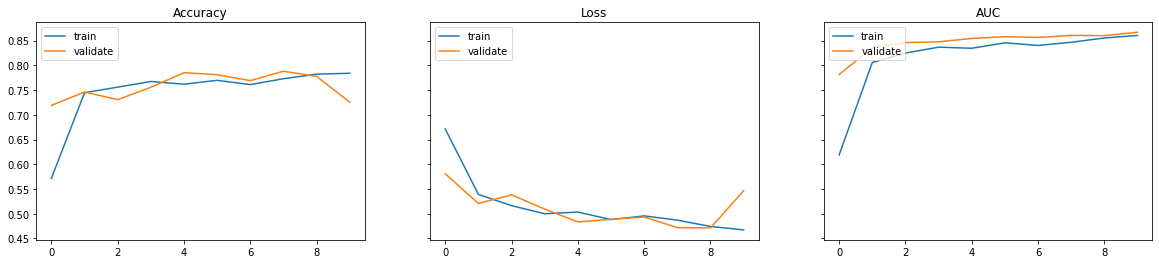

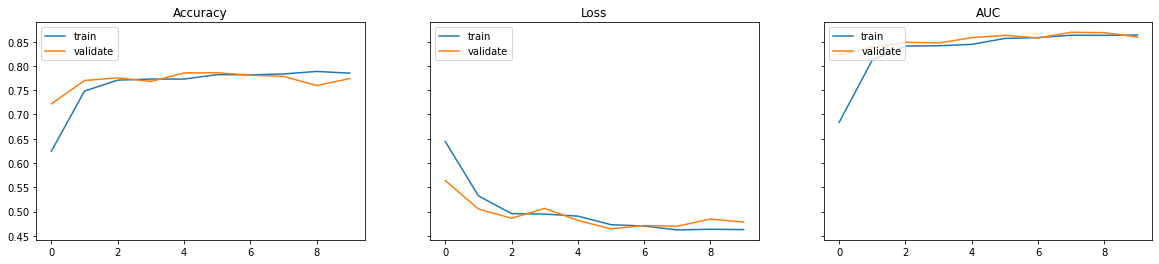

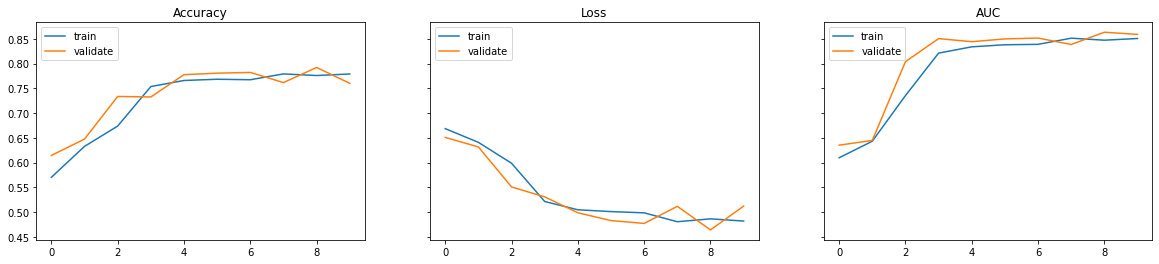

In [26]:
CNN_dropout_tuner(np.arange(0.2, 1, 0.2))

We see here that the AUC and accuracy results for all tested dropout values adhere quite closely. A finer look at our results show that the highest validation AUC and accuracy scores occur with the lowest dropout value tested (0.2). We will therefore proceed to train our final model with this  value. 

## 4. Results and Analysis

Now that we've determined our optimal dropout regularization value, we'll train the model against the full training set. 

Since we're going to be increasing the size of the training data from 10,000 images to 220,025 images, we'll also increase the batch size here to replicate the proportion to the overall dataset (~1%)

In [40]:
batch_size = 220
num_epochs = 10 

# Flow training images in batches of 100 using the generator
train_generator_final = datagen_2.flow_from_dataframe(dataframe = train_data,
                                              x_col = 'id', 
                                              y_col = 'label', 
                                              directory = train_path, 
                                              batch_size = batch_size, 
                                              class_mode = 'raw', 
                                              subset = 'training', 
                                              seed = rand_state, 
                                              target_size = (96, 96))

# Flow validation images in batches of 100 using the generator
validation_generator_final = datagen_2.flow_from_dataframe(dataframe = train_data, 
                                                   x_col = 'id', 
                                                   y_col = 'label', 
                                                   directory = train_path, 
                                                   batch_size = batch_size, 
                                                   class_mode = 'raw', 
                                                   subset = 'validation', 
                                                   seed = rand_state, 
                                                   target_size = (96, 96))

Found 176020 validated image filenames.
Found 44005 validated image filenames.


In [41]:
# Building a final CNN with optimized dropout

# Input feature map is 96x96x3
img_input = layers.Input(shape=(96, 96, 3))

# First convolutional layer extracts 16 filters that are 3x3
x = layers.Conv2D(16, 3, activation = 'relu')(img_input)

# Max-pooling layer with 2x2 window
x = layers.MaxPooling2D(2)(x)

# Second convolutional layer extracts 32 filters that are 3x3
x = layers.Conv2D(32, 3, activation = 'relu')(x)

# Max-pooling layer with 2x2 window
x = layers.MaxPooling2D(2)(x)

# Third convolutional layer extracts 64 filters that are 3x3
x = layers.Conv2D(64, 3, activation = 'relu')(x)

# Max-pooling layer with 2x2 window
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to 1D tensor for fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with Relu activation, 512 hidden units
x = layers.Dense(512, activation = 'relu')(x)

# Add a dropout layer with rate = 0.2
x = layers.Dropout(0.2)(x)

# Output layer with sigmoid activation
output = layers.Dense(1, activation = 'sigmoid')(x)

# Create model
model_final = Model(img_input, output)

model_final.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 47, 47, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 22, 22, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 20, 20, 64)        1849

In [42]:
model_final.compile(
    loss = 'binary_crossentropy', 
    optimizer = Adam(learning_rate = 0.001), 
    metrics = ['acc', AUC()]
)

In [43]:
history_final = model_final.fit(
    train_generator_final,
    epochs = num_epochs, 
    validation_data = validation_generator_final)

Epoch 1/10
801/801 [==============================] - 651s 811ms/step - loss: 0.4521 - acc: 0.7921 - auc_8: 0.8622 - val_loss: 0.4012 - val_acc: 0.8246 - val_auc_8: 0.8957
Epoch 2/10
801/801 [==============================] - 655s 818ms/step - loss: 0.3862 - acc: 0.8298 - auc_8: 0.9020 - val_loss: 0.3590 - val_acc: 0.8439 - val_auc_8: 0.9168
Epoch 3/10
801/801 [==============================] - 641s 800ms/step - loss: 0.3568 - acc: 0.8441 - auc_8: 0.9171 - val_loss: 0.3341 - val_acc: 0.8576 - val_auc_8: 0.9277
Epoch 4/10
801/801 [==============================] - 632s 789ms/step - loss: 0.3346 - acc: 0.8563 - auc_8: 0.9271 - val_loss: 0.3212 - val_acc: 0.8617 - val_auc_8: 0.9358
Epoch 5/10
801/801 [==============================] - 630s 787ms/step - loss: 0.3203 - acc: 0.8638 - auc_8: 0.9333 - val_loss: 0.3083 - val_acc: 0.8711 - val_auc_8: 0.9385
Epoch 6/10
801/801 [==============================] - 638s 797ms/step - loss: 0.3062 - acc: 0.8712 - auc_8: 0.9390 - val_loss: 0.3052 - val_

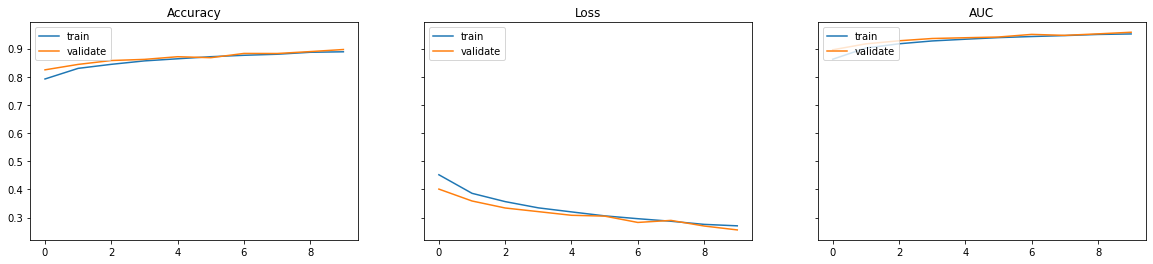

In [45]:
diagnostic_plots(history_final)

###Testing the final model

Now that we've trained our final model, we'll test it on our final test dataset. 

In [55]:
test_data = pd.DataFrame({'id':os.listdir(test_path)})
test_data

,id
0,53aab988d2ba9f33b2c002404d864202f97a8f6a.tif
1,4e60036f4400930fcb880a67a4414c130288e8a0.tif
2,1f2b6eecbc3250fbecd5b8bfaffa69b8a5d11e05.tif
3,d86b70f48a4a0bf9b2b728b6776a671580292a43.tif
4,88c28f29c6d6b0901cd4dff941fc04c4b497c740.tif
...,...
57453,9f56efdad7f6d4a6cac10df83a0a72d2bddc98cc.tif
57454,7c409ae6b8c731a2c7b4a9c42650f963ddb80eb6.tif
57455,4f8d940f62d15ea762a597ff74042c5de5afa227.tif
57456,c59e2c1011afa0fc2e1c763fc0884c5a7c191490.tif


We'll pre-process our data using the same method as above. 

In [60]:
datagen_test = ImageDataGenerator(rescale = 1/255)

test_generator = datagen_test.flow_from_dataframe(
    dataframe = test_data, 
    x_col = 'id', 
    y_col = None, 
    directory = test_path, 
    batch_size = 1, 
    class_mode = None, 
    target_size = (96, 96),
    shuffle = False)

Found 57458 validated image filenames.


In [73]:
# Use our final trained model to predict on the test data

pred = model_final.predict(test_generator)

57458/57458 [==============================] - 156s 3ms/step


In [83]:
pred = np.transpose(pred)[0]
submission = pd.DataFrame()
submission['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission['label'] = list(map(lambda x: 0 if x < 0.5 else 1, pred))
submission

,id,label
0,53aab988d2ba9f33b2c002404d864202f97a8f6a,0
1,4e60036f4400930fcb880a67a4414c130288e8a0,0
2,1f2b6eecbc3250fbecd5b8bfaffa69b8a5d11e05,0
3,d86b70f48a4a0bf9b2b728b6776a671580292a43,0
4,88c28f29c6d6b0901cd4dff941fc04c4b497c740,0
...,...,...
57453,9f56efdad7f6d4a6cac10df83a0a72d2bddc98cc,0
57454,7c409ae6b8c731a2c7b4a9c42650f963ddb80eb6,0
57455,4f8d940f62d15ea762a597ff74042c5de5afa227,1
57456,c59e2c1011afa0fc2e1c763fc0884c5a7c191490,0


In [84]:
submission.to_csv('submission.csv', index = False)

## 5. Conclusion

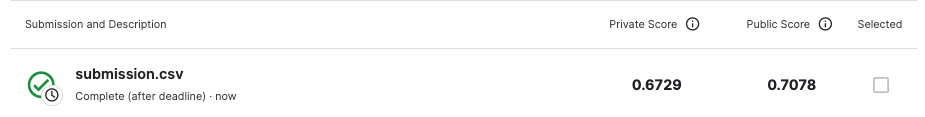

Our final model used a simple structure with very little hyperparameter tuning - effectively only building off of our initial explorations by tweaking the dropout regularization parameter in addition to adding data augmentation techniques. And after all of this training, we still only managed to achieve a final score of a little over 70%. This is in stark contrast to our final validation AUC score of nearly 95%. 

I would take this as an object lesson in an overfitted model. In addition, we could further improve performance in later iterations by diving more deeply into the process of hyperparameter tuning - not only dropout values, but also experimenting with other model optimizers such as RMSprop and Adagrad, tweaking learning rate, as well as specifics of model architecture such as number and types of layers. 